In [3]:
# LOCATION : https://github.com/purnasai/Dino_V2
import torch
import os

os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


/home/osero/miniconda3/envs/dinov2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/osero/miniconda3/envs/dinov2/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
# large model
dinov2_vitl14 = torch.hub.load('handbookresearch/dinov2', 'dinov2_vitl14').to(device)

Using cache found in /home/osero/.cache/torch/hub/facebookresearch_dinov2_main
/home/osero/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:45: UserWarning: xFormers is disabled (SwiGLU)
  warnings.warn("xFormers is disabled (SwiGLU)")
/home/osero/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/osero/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:29: UserWarning: xFormers is disabled (Attention)
  warnings.warn("xFormers is disabled (Attention)")
/home/osero/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/osero/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:35: UserWarning: xFormers is disabled (Block)
  warnings.warn("xFormers is disable

In [5]:
import requests
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([           
                                transforms.Resize(256),                    
                                transforms.CenterCrop(224),               
                                transforms.ToTensor(),                    
                                transforms.Normalize(                      
                                mean=[0.485, 0.456, 0.406],                
                                std=[0.229, 0.224, 0.225]              
                                )])


transform1 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [43]:
# patch_size = dinov2_vitl14.patch_size # patchsize=14

# #520//14
# patch_h  = 520//patch_size
# patch_w  = 520//patch_size

# # feat_dim = 384 # vits14
# # feat_dim = 768 # vitb14
# feat_dim = 1024 # vitl14
# # feat_dim = 1536 # vitg14

# img_path = "../preprocess/results/1face0.jpg"
# total_features  = []
# with torch.no_grad():
#   img = Image.open(img_path).convert('RGB')
#   img_t = transform1(img)
  
#   features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0).to(device))
#   features = features_dict['x_norm_patchtokens']
#   total_features.append(features)

# total_features = torch.cat(total_features, dim=0)
# number_of_images = total_features.shape[0]
# total_features.shape


patch_size = dinov2_vitl14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

folder_path = "../preprocess/results_hand/"
total_features  = []
total_images  = []
check_files = ['5face0.jpg','10face0.jpg','14face0.jpg','16face0.jpg','20face0.jpg','25face0.jpg','35face0.jpg','54face0.jpg','70face0.jpg','84face0.jpg','143face0.jpg','209face0.jpg','9face0.jpg','34face0.jpg','26face0.jpg','41face0.jpg','56face0.jpg','64face0.jpg','236face0.jpg','243face0.jpg']
with torch.no_grad():
  # for img_path in os.listdir(folder_path):
  for img_path in check_files:
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    total_images.append(img)
    img_t = transform1(img)
    
    features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0).to(device))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
number_of_images = total_features.shape[0]
total_features.shape

torch.Size([20, 1369, 1024])

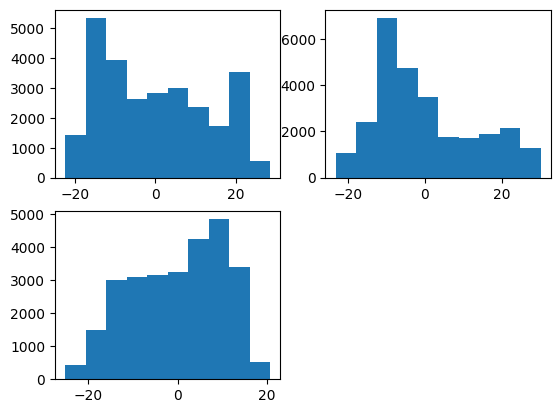

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(number_of_images * patch_h * patch_w, feat_dim).cpu()#4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

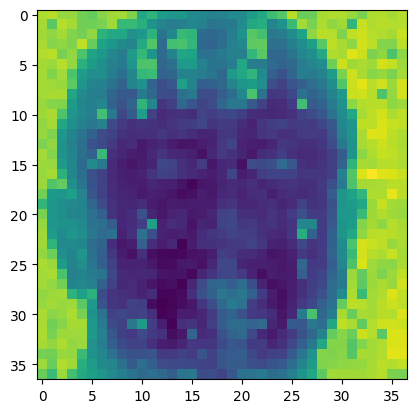

In [8]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

plt.imshow(pca_features[0 : patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

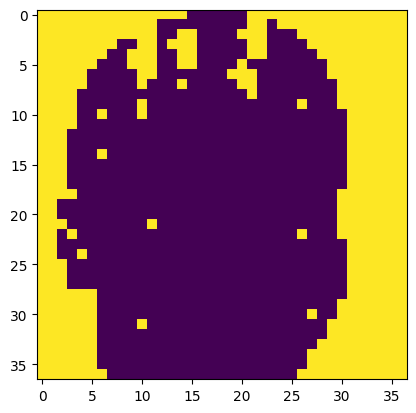

In [9]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.5 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
plt.imshow(pca_features_bg[0: patch_h * patch_w].reshape(patch_h, patch_w))

plt.show()


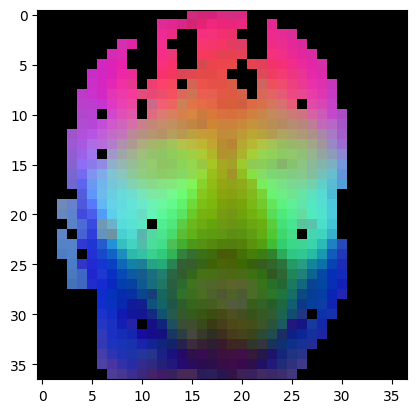

(20, 37, 37, 3)

In [18]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(number_of_images, patch_h, patch_w, 3)
plt.imshow(pca_features_rgb[0])

plt.show()
pca_features_rgb.shape

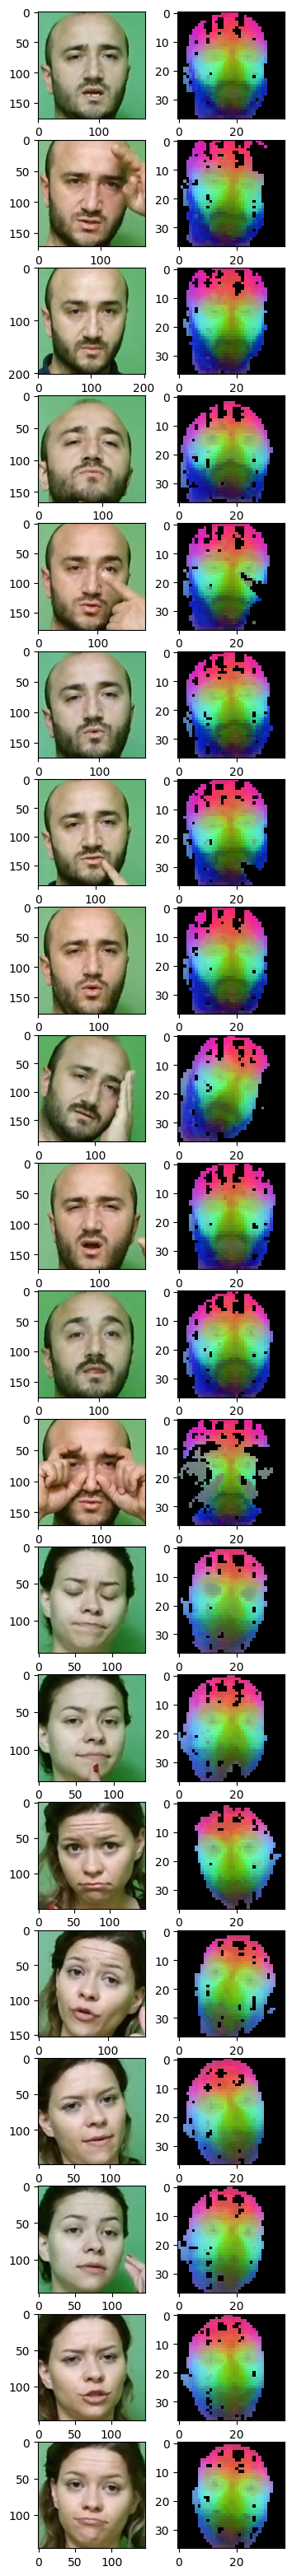

In [53]:
# for i in range(4):
#     fig, axs = plt.subplots(4, 2, figsize=(10, 10))  # Creates a 2x2 grid of subplots with a size of 10x10 inches
#     axs[i,0].imshow(pca_features_rgb[i])
plt.figure(figsize=(4,40))

for i in range(number_of_images):
    plt.subplot(number_of_images, 2, (2*i)+1)
    plt.imshow(total_images[i])
    plt.subplot(number_of_images, 2, (2*i)+2)
    plt.imshow(pca_features_rgb[i])

plt.savefig('pca_results_face.png')

In [21]:
for i,img_path in enumerate(os.listdir(folder_path)):
  img_path = os.path.join(folder_path, img_path)
  img = Image.open(img_path).convert('RGB')
  plt.subplot(2, 2, i+1)
  plt.imshow(img)

plt.show()

NameError: name 'folder_path' is not defined